# Bayes by Backprop
An implementation of the algorithm described in https://arxiv.org/abs/1505.05424.  
This notebook accompanies the article at https://www.nitarshan.com/bayes-by-backprop.

In [2]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [3]:
import torch.utils.data as data
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [4]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device", DEVICE)
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.backends.mps.is_available() else {}
print(torch.backends.mps.is_available())

device mps
True


## Data Preparation

In [5]:
# WE FIRST WORK ON A BINARY CLASSIFICATION DATASET 
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 26
TEST_BATCH_SIZE = 4
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])


# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/emmaprevot/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/emmaprevot/.medmnist/breastmnist.npz
Using downloaded and verified file: /Users/emmaprevot/.medmnist/breastmnist.npz


"breastmnist": {
        "python_class": "BreastMNIST",
        "description":
        "The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.",
        "url":
        "https://zenodo.org/record/6496656/files/breastmnist.npz?download=1",
        "MD5": "750601b1f35ba3300ea97c75c52ff8f6",
        "task": "binary-class",
        "label": {
            "0": "malignant",
            "1": "normal, benign"
        },
        "n_channels": 1,
        "n_samples": {
            "train": 546,
            "val": 78,
            "test": 156
        },
        "license": "CC BY 4.0"
    },

In [73]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BreastMNIST (breastmnist)
    Number of datapoints: 546
    Root location: /Users/emmaprevot/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST (breastmnist)
    Number of datapoints: 156
    Root location: /Users/emmaprevot/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels

In [ ]:
train_dataset.montage(length=1)

In [6]:
TRAIN_SIZE = len(train_dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

print(TRAIN_SIZE)
print(TEST_SIZE)

CLASSES = 2
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

546
156


In [34]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        './fmnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 50
SAMPLES = 2
TEST_SAMPLES = 10

assert (TRAIN_SIZE % BATCH_SIZE) == 0
assert (TEST_SIZE % TEST_BATCH_SIZE) == 0

## Modelling
$$\underline{\text{Reparameterized Gaussian}}$$
$$\begin{aligned}
\theta &= (\mu, \rho)\\
\sigma &= \ln{(1+e^\rho)}\\
\mathcal{N}(x\vert \mu, \sigma) &= \frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{(x-\mu)^2}{2\sigma^2}}\\
\ln{\mathcal{N}(x\vert \mu, \sigma)} &= -\ln{\sqrt{2\pi}} -\ln{\sigma} -\frac{(x-\mu)^2}{2\sigma^2}\\
P(\mathbf{w}) &= \prod_j{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{\mathcal{N}(\mathbf{w}_j \vert 0, \sigma^2)}}\\
\end{aligned}$$

In [7]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

$$\underline{\text{Scale Mixture Gaussian}}$$
$$\begin{align}
P(\mathbf{w}) &= \prod_j{\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2)}\\
\ln{P(\mathbf{w})} &= \sum_j{\ln{(\pi \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_1^2) + (1-\pi) \mathcal{N}(\mathbf{w}_j \vert 0, \sigma_2^2))}}\\
\end{align}$$

In [8]:
class ScaleMixtureGaussian(object):
    def __init__(self, pi, sigma1, sigma2):
        super().__init__()
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian2.log_prob(input))
        return (torch.log(self.pi * prob1 + (1-self.pi) * prob2)).sum()

$$\pi = \frac{1}{2}$$
$$-\ln{\sigma_1} = 0$$
$$-\ln{\sigma_2} = 6$$

In [9]:
PI = 0.5
SIGMA_1 = torch.FloatTensor([math.exp(-0)]).to(DEVICE)
SIGMA_2 = torch.FloatTensor([math.exp(-6)]).to(DEVICE)

def visualize_scale_mixture_components():
    def show_lines():
        pass
    mix = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
    normal_1 = torch.distributions.Normal(0, SIGMA_1)
    normal_2 = torch.distributions.Normal(0, SIGMA_2)
    x_points = np.linspace(-5,5,10000)
    d1 = np.array([torch.exp(normal_1.log_prob(float(c))) for c in x_points])
    d2 = np.array([torch.exp(normal_2.log_prob(float(c))) for c in x_points])
    d3 = np.array([torch.exp(mix.log_prob(float(c))) for c in x_points])
    plt.subplots(1,3,figsize=(14,4))
    plt.subplot(1,3,1)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,0.5)
    plt.subplot(1,3,2)
    plt.plot(x_points,d1,color="b")
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.legend(["sigma1", "sigma2", "mix"])
    plt.ylim(0,160)
    plt.subplot(1,3,3)
    plt.plot(x_points,d2,color="g")
    plt.plot(x_points,d3,color="r")
    plt.plot(x_points,d1,color="b")
    plt.legend(["sigma2", "mix", "sigma1"])
    plt.ylim(0,80)
    
#visualize_scale_mixture_components()

In [10]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        # Weight parameters
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        # Bias parameters
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        # Prior distributions
        self.weight_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.bias_prior = ScaleMixtureGaussian(PI, SIGMA_1, SIGMA_2)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [11]:
class BayesianNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # for breast 28*28 and OUT 2
        # for MNIST and FMINSt 28*28 and OUT 10
        self.l1 = BayesianLinear(28*28, 400)
        self.l2 = BayesianLinear(400, 400)
        self.l3 = BayesianLinear(400, 2)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.log_softmax(self.l3(x, sample), dim=1)
        return x
    
    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def sample_elbo(self, input, target, samples=SAMPLES):
        
        outputs = torch.zeros(samples, BATCH_SIZE, CLASSES).to(DEVICE)
        #print("OUTPUT", outputs.shape)
        #print("INPUT", input.shape)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        loss = (log_variational_posterior - log_prior)/NUM_BATCHES + negative_log_likelihood
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

net = BayesianNetwork().to(DEVICE)

## Training

In [12]:
def write_weight_histograms(epoch):
    writer.add_histogram('histogram/w1_mu', net.l1.weight_mu,epoch)
    writer.add_histogram('histogram/w1_rho', net.l1.weight_rho,epoch)
    writer.add_histogram('histogram/w2_mu', net.l2.weight_mu,epoch)
    writer.add_histogram('histogram/w2_rho', net.l2.weight_rho,epoch)
    writer.add_histogram('histogram/w3_mu', net.l3.weight_mu,epoch)
    writer.add_histogram('histogram/w3_rho', net.l3.weight_rho,epoch)
    writer.add_histogram('histogram/b1_mu', net.l1.bias_mu,epoch)
    writer.add_histogram('histogram/b1_rho', net.l1.bias_rho,epoch)
    writer.add_histogram('histogram/b2_mu', net.l2.bias_mu,epoch)
    writer.add_histogram('histogram/b2_rho', net.l2.bias_rho,epoch)
    writer.add_histogram('histogram/b3_mu', net.l3.bias_mu,epoch)
    writer.add_histogram('histogram/b3_rho', net.l3.bias_rho,epoch)

def write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood):
    writer.add_scalar('logs/loss', loss, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/complexity_cost', log_variational_posterior-log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_prior', log_prior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/log_variational_posterior', log_variational_posterior, epoch*NUM_BATCHES+batch_idx)
    writer.add_scalar('logs/negative_log_likelihood', negative_log_likelihood, epoch*NUM_BATCHES+batch_idx)

In [13]:
def train(net, optimizer, epoch):
    net.train()
    if epoch == 0: # write initial distributions
        write_weight_histograms(epoch)
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        target = target.squeeze().long()
        data, target = data.to(DEVICE), target.to(DEVICE)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target)
        loss.backward()
        optimizer.step()
        write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    write_weight_histograms(epoch+1)

In [14]:
optimizer = optim.Adam(net.parameters())
for epoch in range(40):
    train(net, optimizer, epoch)

path = 'Results/BBB_breast_400_adam_ID0_notebook'
torch.save(net.state_dict(), path + '.pth')

  0%|          | 0/21 [00:00<?, ?it/s]/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


## Evaluation

### Model Ensemble

In [15]:
def test_ensemble():
    net.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = net(data, sample=True)
            outputs[TEST_SAMPLES] = net(data, sample=False)
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
            correct += pred.eq(target.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

Component 0 Accuracy: 126/156
Component 1 Accuracy: 129/156
Component 2 Accuracy: 128/156
Component 3 Accuracy: 132/156
Component 4 Accuracy: 125/156
Component 5 Accuracy: 127/156
Component 6 Accuracy: 127/156
Component 7 Accuracy: 128/156
Component 8 Accuracy: 130/156
Component 9 Accuracy: 121/156
Posterior Mean Accuracy: 128/156
Ensemble Accuracy: 127/156


### Model Uncertainty

#### In-Domain Uncertainty

In [17]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0],
        [1],
        [1],
        [1]])


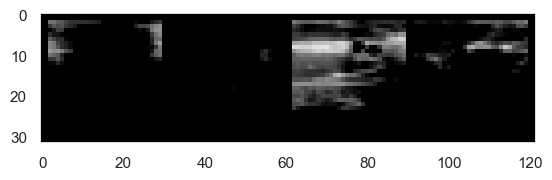

In [18]:
dataiter = iter(test_loader)
sample = next(dataiter)

sample[0] = sample[0].to(DEVICE)
print(sample[1])
sns.set_style("dark")
show(make_grid(sample[0].cpu()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1],
        [1],
        [1],
        [1]])


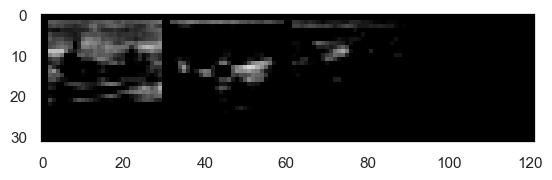

In [26]:
sample = next(dataiter)
sample[0] = sample[0].to(DEVICE)
print(sample[1])
sns.set_style("dark")
show(make_grid(sample[0].cpu()))

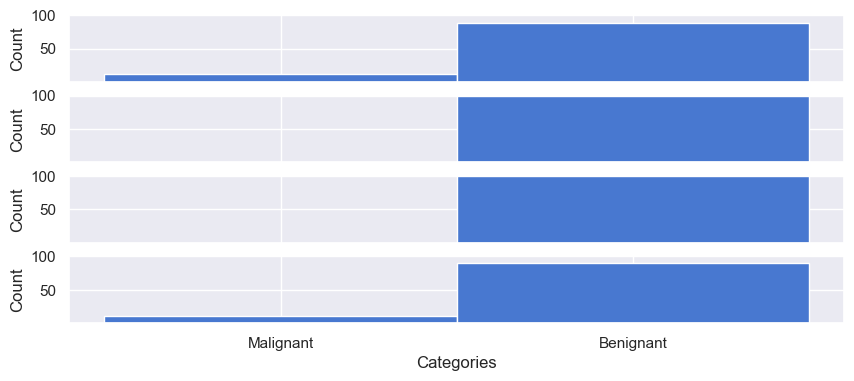

In [27]:
net.eval()
outputs = net(sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    outputs = np.append(outputs, net(sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(4,1,figsize=(10,4))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    #plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.xticks(range(2), ["Malignant", "Benignant"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(outputs[i], np.arange(-0.5, 2, 1))

#### Out-of-Domain Uncertainty

In [37]:
info = INFO['pneumoniamnist']
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=True)
ood_loader = data.DataLoader(dataset=train_dataset,  batch_size=4, shuffle=True)

Using downloaded and verified file: /Users/emmaprevot/.medmnist/pneumoniamnist.npz


"pneumoniamnist": {
        "python_class": "PneumoniaMNIST",
        "description":
        "The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.",
        "url":
        "https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1",
        "MD5": "28209eda62fecd6e6a2d98b1501bb15f",
        "task": "binary-class",
        "label": {
            "0": "normal",
            "1": "pneumonia"
        },
        "n_channels": 1,
        "n_samples": {
            "train": 4708,
            "val": 524,
            "test": 624
        },
        "license": "CC BY 4.0"
    },

In [23]:
mnist_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)

tensor([7, 2, 1, 0, 4])


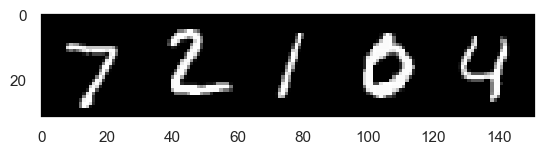

In [24]:
dataiter = iter(mnist_loader)
ood_sample = next(dataiter)

ood_sample[0] = ood_sample[0].to(DEVICE)
print(ood_sample[1])
sns.set_style("dark")
show(make_grid(ood_sample[0].cpu()))

/var/folders/47/7414tgbs2kz1x5ql498d6hth0000gn/T/ipykernel_48162/1157789764.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,1,i+1)


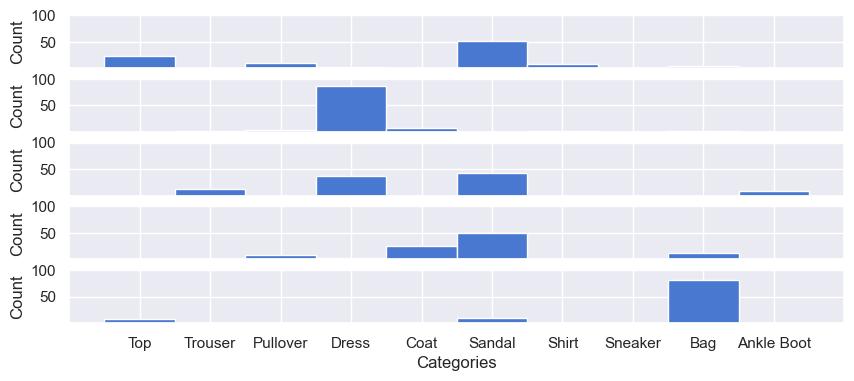

In [25]:
net.eval()
ood_outputs = net(ood_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    ood_outputs = np.append(ood_outputs, net(ood_sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)

sns.set_style("darkgrid")
plt.subplots(4,1,figsize=(10,4))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(ood_outputs[i], np.arange(-0.5, 10, 1))

# Weight Pruning

In [28]:
HIDDEN = 400
modelpath = "Results/BBB_breast_400_adam_ID0_notebook.pth"

model = BayesianNetwork()

model.load_state_dict(torch.load(modelpath, map_location='cpu'))
model.eval()

BayesianNetwork(
  (l1): BayesianLinear()
  (l2): BayesianLinear()
  (l3): BayesianLinear()
)

In [29]:
def getThreshold(model,buckets):
    sigmas = []
    mus = []

    sigmas.append(model.state_dict()['l1.weight_rho'].view(-1).cpu().detach().numpy())
    sigmas.append(model.state_dict()['l2.weight_rho'].view(-1).cpu().detach().numpy())
    sigmas.append(model.state_dict()['l3.weight_rho'].view(-1).cpu().detach().numpy())

    mus.append(model.state_dict()['l1.weight_mu'].view(-1).cpu().detach().numpy())
    mus.append(model.state_dict()['l2.weight_mu'].view(-1).cpu().detach().numpy())
    mus.append(model.state_dict()['l3.weight_mu'].view(-1).cpu().detach().numpy())
    

    sigmas = np.concatenate(sigmas).ravel()
    mus = np.concatenate(mus).ravel()
    sigmas = np.log(1. + np.exp(sigmas))
    sign_to_noise = np.abs(mus) / sigmas
    p = np.percentile(sign_to_noise, buckets)
    
    s = np.log10(sign_to_noise)/10
    hist, bin_edges = np.histogram(s, bins='auto')
    hist = hist / s.size
    X =[]
    for i in range(hist.size):
        X.append((bin_edges[i]+bin_edges[i+1])*0.5)
    
    plt.plot(X,hist)
    plt.axvline(x= np.log10(p[2])/10, color='red')
    plt.ylabel('Density')
    plt.xlabel('Signal−to−Noise Ratio (dB)')
    plt.savefig('./Results/SignalToNoiseRatioDensity_400_breast.png')
    plt.savefig('./Results/SignalToNoiseRatioDensity_400_breast.eps', format='eps', dpi=1000)

    plt.figure(2)
    Y = np.cumsum(hist)
    plt.plot(X, Y)
    plt.axvline(x= np.log10(p[2])/10, color='red')
    plt.hlines(y= 0.75, xmin=np.min(s),xmax=np.max(s),colors='red')
    plt.ylabel('CDF')
    plt.xlabel('Signal−to−Noise Ratio (dB)')
    plt.savefig('./Results/SignalToNoiseRatioDensity_CDF_400_breast.png')
    plt.savefig('./Results/SignalToNoiseRatioDensity_CDF_400_breast.eps', format='eps', dpi=1000)
    
    return p

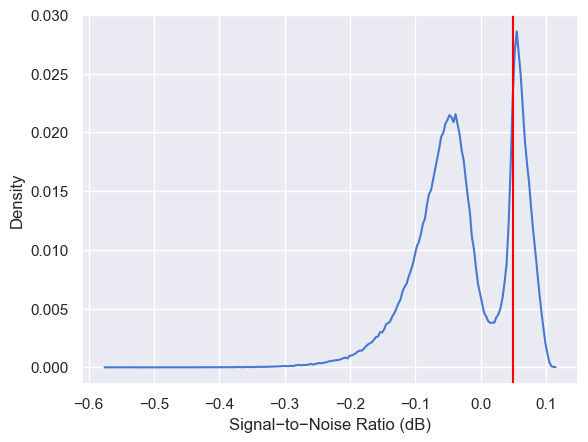

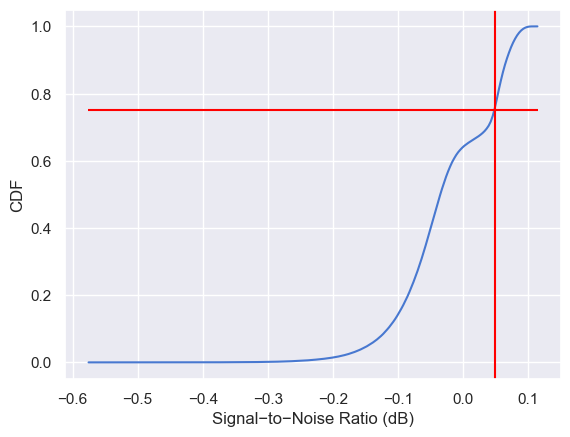

In [30]:
buckets = np.asarray([0,50,75,95,98])
thresholds = getThreshold(model,buckets)
model_name = modelpath.split("/")[1].split(".")[0]

In [32]:
import copy
from torch.autograd import Variable

for index in range(buckets.size):
    print(buckets[index],'-->',thresholds[index])
    t = Variable(torch.Tensor([thresholds[index]]))
    model1 = copy.deepcopy(model)
    for i in range(1, 4):
        rho = model.state_dict()['l'+str(i)+'.weight_rho']
        mu = model.state_dict()['l'+str(i)+'.weight_mu'] 
        sigma = np.log(1. + np.exp(rho.cpu().numpy()))
        signalRatio = np.abs(mu.cpu().numpy()) / sigma
        signalRatio = (torch.from_numpy(signalRatio) > t).float() * 1
        model1.state_dict()['l'+str(i)+'.weight_rho'].data.copy_(rho * signalRatio)
        model1.state_dict()['l'+str(i)+'.weight_mu'].data.copy_(mu * signalRatio)

    torch.save(model1.state_dict(), 'Models/' + model_name + '_Pruned_'+str(buckets[index])+'.pth')

0 --> 1.7018546714098193e-06
50 --> 0.4632915258407593
75 --> 3.1207922101020813
95 --> 6.024212479591369
98 --> 7.426092672348022


## Evaluate pruned models

In [33]:
import os
for root, dirs, files in os.walk("Models/"):
    for file in files:
        if file.startswith('BBB_breast_400') and file.endswith(".pth"):
            print(file)
            pruned_model = BayesianNetwork().to(DEVICE)
            pruned_model.load_state_dict(torch.load('Models/' + file))
            pruned_model.eval()

            correct = 0
            corrects = np.zeros(TEST_SAMPLES+1, dtype=int)
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(DEVICE), target.to(DEVICE)
                    outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
                    for i in range(TEST_SAMPLES):
                        outputs[i] = pruned_model(data, sample=True)
                    outputs[TEST_SAMPLES] = pruned_model(data, sample=False)
                    output = outputs.mean(0)
                    preds = preds = outputs.max(2, keepdim=True)[1]
                    pred = output.max(1, keepdim=True)[1] # index of max log-probability
                    corrects += preds.eq(target.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
                    correct += pred.eq(target.view_as(pred)).sum().item()
            for index, num in enumerate(corrects):
                if index < TEST_SAMPLES:
                    print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
                else:
                    print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
            print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

BBB_breast_400_adam_ID0_notebook_Pruned_50.pth
Component 0 Accuracy: 99/156
Component 1 Accuracy: 78/156
Component 2 Accuracy: 78/156
Component 3 Accuracy: 90/156
Component 4 Accuracy: 87/156
Component 5 Accuracy: 74/156
Component 6 Accuracy: 91/156
Component 7 Accuracy: 73/156
Component 8 Accuracy: 86/156
Component 9 Accuracy: 87/156
Posterior Mean Accuracy: 127/156
Ensemble Accuracy: 92/156
BBB_breast_400_adam_ID0_notebook_Pruned_95.pth
Component 0 Accuracy: 86/156
Component 1 Accuracy: 81/156
Component 2 Accuracy: 67/156
Component 3 Accuracy: 81/156
Component 4 Accuracy: 96/156
Component 5 Accuracy: 81/156
Component 6 Accuracy: 90/156
Component 7 Accuracy: 71/156
Component 8 Accuracy: 86/156
Component 9 Accuracy: 77/156
Posterior Mean Accuracy: 112/156
Ensemble Accuracy: 88/156
BBB_breast_400_adam_ID0_notebook_Pruned_98.pth
Component 0 Accuracy: 84/156
Component 1 Accuracy: 78/156
Component 2 Accuracy: 76/156
Component 3 Accuracy: 82/156
Component 4 Accuracy: 71/156
Component 5 Accu

## Uncertainty of the pruned model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0],
        [1],
        [1],
        [1]])


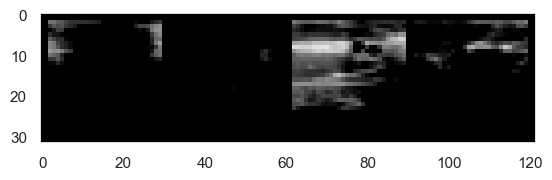

In [34]:
pruned_model = BayesianNetwork().to(DEVICE)
pruned_model.load_state_dict(torch.load('Models/BBB_breast_400_adam_ID0_notebook_Pruned_50.pth'))


dataiter = iter(test_loader)
sample = next(dataiter)

sample[0] = sample[0].to(DEVICE)
print(sample[1])
sns.set_style("dark")
show(make_grid(sample[0].cpu()))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[1],
        [1],
        [1],
        [1]])


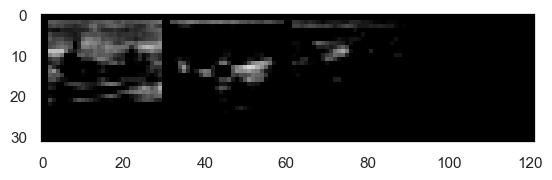

In [38]:
sample = next(dataiter)

sample[0] = sample[0].to(DEVICE)
print(sample[1])
sns.set_style("dark")
show(make_grid(sample[0].cpu()))

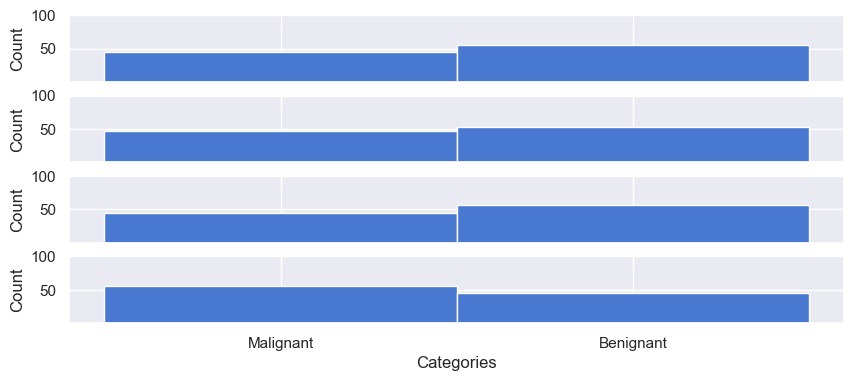

In [39]:

pruned_model.eval()
outputs = pruned_model(sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy()
for _ in range(99):
    outputs = np.append(outputs, pruned_model(sample[0], True).max(1, keepdim=True)[1].detach().cpu().numpy(), axis=1)
sns.set_style("darkgrid")
plt.subplots(4,1,figsize=(10,4))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.ylim(0,100)
    plt.xlabel("Categories")
    plt.xticks(range(2), ["Malignant", "Benignant"])
    #plt.xticks(range(10), ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"])
    plt.ylabel("Count")
    plt.yticks(range(50,101,50))
    plt.hist(outputs[i], np.arange(-0.5, 2, 1))